# Theoretical Bound vs Numerical Bound

Given we want to solve $\textbf{P}w = b$, where $\textbf{P}$ is the  circulant matrix used in the ParaDiag scheme, given that the linear solve is inexact with a tolerance $\tau$, we have the bound
$$
\left \| \Delta w \right \|_{\infty} \leq \frac{\tau N_t \|B^{-1}\|}{\alpha}\left \| x \right \|_{\infty}
$$
We consider solving a linear equation of the form $\textbf{P}^{-1} Aq = \textbf{P}^{-1}c$. Then, using modified Richardson iterations, we are essentially solving for 
$$
\textbf{P}w = (c - \textbf{A}q) = b
$$
In the ParaDiag case for the scalar advection equation, we have the expression 
$$
\textbf{A}\textbf{q} = \left(\frac{1}{\Delta t}\textbf{B}_{1}\otimes\textbf{M} + \textbf{B}_{2}\otimes\textbf{K}\right)\textbf{q}
$$
The right hand side vector $\textbf{c}$ contains the initial condition:

$$
\begin{pmatrix}
q^{0}/\Delta t - (1-\theta)\textbf{K}q^{0} \\ 0 \\ 0 \\ 0
\end{pmatrix}
$$

We analyse only the first iteration. Then, the inner solve becomes 
$$
Pw = (c - \textbf{A}q_{inital})
$$

To start, we set up the all-at-once matrix $\textbf{A}$.

In [86]:
from math import pi
import numpy as np

nt = 128
nx = 128

lx = 2*pi
dx = lx/nx

theta = 0.5

# velocity, CFL, and reynolds number
u = 1
re = 500
cfl = 0.8

# viscosity and timestep
nu = lx*u/re
dt = cfl*dx/u

# advective and diffusive Courant numbers

cfl_u = cfl
cfl_v = nu*dt/dx**2

print(f"{nu = }, {dt = }, {cfl_v = }, {cfl_u = }")

# Spatial domain
mesh = np.linspace(start=-lx/2, stop=lx/2, num=nx, endpoint=False)

nu = 0.012566370614359173, dt = 0.039269908169872414, cfl_v = 0.2048, cfl_u = 0.8


In [87]:
from scipy import sparse
from scipy import linalg
from scipy.sparse import linalg as spla

# Finite difference spatial discretisations                                                                                                                                                   
def gradient_stencil(grad, order):                                                                                                                                                            
    '''                                                                                                                                                                                       
    Return the centred stencil for the `grad`-th gradient                                                                                                                                     
    of order of accuracy `order`                                                                                                                                                              
    '''                                                                                                                                                                                       
    return {                                                                                                                                                                                  
        1: {  # first gradient                                                                                                                                                                
            2: np.array([-1/2, 0, 1/2]),                                                                                                                                                      
            4: np.array([1/12, -2/3, 0, 2/3, -1/12]),                                                                                                                                         
            6: np.array([-1/60, 3/20, -3/4, 0, 3/4, -3/20, 1/60])                                                                                                                             
        },                                                                                                                                                                                    
        2: {  # second gradient                                                                                                                                                               
            2: np.array([1, -2, 1]),                                                                                                                                                          
            4: np.array([-1/12, 4/3, -5/2, 4/3, -1/12]),                                                                                                                                      
            6: np.array([1/90, -3/20, 3/2, -49/18, 3/2, -3/20, 1/90])                                                                                                                         
        },                                                                                                                                                                                    
        4: {  # fourth gradient                                                                                                                                                               
            2: np.array([1,  -4, 6, -4, 1]),                                                                                                                                                  
            4: np.array([-1/6, 2, -13/2, 28/3, -13/2, 2, -1/6]),                                                                                                                              
            6: np.array([7/240, -2/5, 169/60, -122/15, 91/8, -122/15, 169/60, -2/5, 7/240])  # noqa: E501                                                                                     
        }                                                                                                                                                                                     
    }[grad][order]                                                                                                                                                                            
                                                                                                                                                                                              
                                                                                                                                                                                              
def sparse_circulant(stencil, n):                                                                                                                                                             
    '''                                                                                                                                                                                       
    Return sparse scipy matrix from finite difference                                                                                                                                         
    stencil on a periodic grid of size n.                                                                                                                                                     
    '''                                                                                                                                                                                       
    if len(stencil) == 1:                                                                                                                                                                     
        return sparse.spdiags([stencil[0]*np.ones(n)], 0)                                                                                                                                     
                                                                                                                                                                                              
    # extend stencil to include periodic overlaps                                                                                                                                             
    ns = len(stencil)                                                                                                                                                                         
    noff = (ns-1)//2                                                                                                                                                                          
    pstencil = np.zeros(ns+2*noff)                                                                                                                                                            
                                                                                                                                                                                              
    pstencil[noff:-noff] = stencil                                                                                                                                                            
    pstencil[:noff] = stencil[noff+1:]                                                                                                                                                        
    pstencil[-noff:] = stencil[:noff]                                                                                                                                                         
                                                                                                                                                                                              
    # constant diagonals of stencil entries                                                                                                                                                   
    pdiags = np.tile(pstencil[:, np.newaxis], n)                                                                                                                                              
                                                                                                                                                                                              
    # offsets for inner domain and periodic overlaps                                                                                                                                          
    offsets = np.zeros_like(pstencil, dtype=int)                                                                                                                                              
                                                                                                                                                                                              
    offsets[:noff] = [-n+1+i for i in range(noff)]                                                                                                                                            
    offsets[noff:-noff] = [-noff+i for i in range(2*noff+1)]                                                                                                                                  
    offsets[-noff:] = [n-noff+i for i in range(noff)]                                                                                                                                         
                                                                                                                                                                                              
    return sparse.spdiags(pdiags, offsets)

In [88]:
# Mass matrix                                                                                                                                                                                 
M = sparse_circulant([1], nx)                                                                                                                                                                 
                                                                                                                                                                                              
# Advection matrix                                                                                                                                                                            
D = sparse_circulant(gradient_stencil(1, order=2), nx)                                                                                                                                        
                                                                                                                                                                                              
# Diffusion matrix                                                                                                                                                                            
L = sparse_circulant(gradient_stencil(2, order=2), nx)

# Spatial terms                                                                                                                                                                               
K = (u/dx)*D - (nu/dx**2)*L

# Generate block matrices for different coefficients                                                                                                                                          
def block_matrix(l1, l2):                                                                                                                                                                     
    mat = l1*M + l2*K                                                                                                                                                                         
    mat.solve = spla.factorized(mat.tocsc())                                                                                                                                                  
    return mat

In [89]:
# Build the full B1 & B2 matrices
b1col = np.zeros(nt)
b1col[0] = 1/dt
b1col[1] = -1/dt

b1row = np.zeros_like(b1col)
b1row[0] = b1col[0]

b2col = np.zeros(nt)
b2col[0] = theta
b2col[1] = 1-theta

b2row = np.zeros_like(b2col)
b2row[0] = b2col[0]

B1 = linalg.toeplitz(b1col, b1row)                                                                                                                                                            
B2 = linalg.toeplitz(b2col, b2row)

# Build the A0 and A1 matrices
A1 = block_matrix(b1col[0], b2col[0])
A0 = block_matrix(b1col[1], b2col[1])

# Now build the full Jacobian A
A = spla.aslinearoperator(sparse.kron(B1, M) + sparse.kron(B2, K))

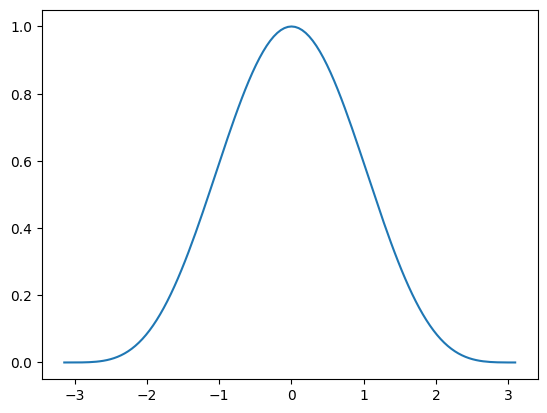

In [ ]:
from math import pi

qinit = np.zeros_like(mesh)
qinit[:] = np.cos(mesh/2)**4

# set up timeseries                                                                                                                                                                           
q = np.zeros(nt*nx)                                                                                                                                                                           
rhs = np.ones_like(q)                                                                                                                                                                        
                                                                                                                                                                                              
q = q.reshape((nt, nx))                                                                                                                                                                       
rhs = rhs.reshape((nt, nx))                                                                                                                                                                   
                                                                                                                                                                                              
# initial guess is constant solution                                                                                                                                                          
q[:] = qinit[np.newaxis, :]                                                                                                                                                                   
rhs[0] -= A0.dot(qinit)                                                                                                                                                                       
                                                                                                                                                                                              
q = q.reshape(nx*nt)
rhs = rhs.reshape(nx*nt)

import matplotlib.pyplot as plt
plt.plot(mesh, qinit)
plt.show()

We first consider a block diagonal matrix of the form $\textbf{B} = \operatorname{diag}(B_1, B_2, \ldots, B_n)$. Letting $\textbf{y} = (y_1, y_2, \ldots, y_n)^{T}$, if we solve an equation of the form $\textbf{B}\textbf{x} = \textbf{y}$, we have that 
$$
\textbf{x} = (B_1^{-1}y_1, B_2^{-1}y_2, \ldots, B_n^{-1}y_n)

We now set up the preconditioner $\textbf{P}$. We construct the ``BlockCirculantLinearOperatorExact`` class, which will implement the inner solve exactly, and the ``BlockCirculantLinearOperatorInexact`` class, which will implement the inner solve inexactly up to a relative tolerance ``tol``, using GMRES iterations.

In [94]:
from scipy.fft import fft, ifft

class BlockCirculantLinearOperatorExact(spla.LinearOperator):
    def __init__(self, b1col, b2col, block_matrix, nx, alpha=1):
        self.nt = len(b1col)
        self.nx = nx
        self.dim = self.nt*self.nx
        self.shape = tuple((self.dim, self.dim))
        self.dtype = b1col.dtype

        self.gamma = alpha**(np.arange(self.nt)/self.nt)

        eigvals1 = fft(b1col*self.gamma, norm='backward')
        eigvals2 = fft(b2col*self.gamma, norm='backward')
        eigvals = zip(eigvals1, eigvals2)

        self.blocks = tuple((block_matrix(l1, l2)
                             for l1, l2 in eigvals))

    def _to_eigvecs(self, v):
        y = np.matmul(np.diag(self.gamma), v)
        return fft(y, axis=0)

    def _from_eigvecs(self, v):
        y = ifft(v, axis=0)
        return np.matmul(np.diag(1/self.gamma), y)

    def _block_solve(self, v):
        for i in range(self.nt):
            v[i] = self.blocks[i].solve(v[i])
        return v

    def _matvec(self, v):
        y = v.reshape((self.nt, self.nx))                                  
        y = self._to_eigvecs(y)
        y = self._block_solve(y)
        y = self._from_eigvecs(y)
        return y.reshape(self.dim).real

In [ ]:
from scipy.fft import fft, ifft

tol = 0.001
class BlockCirculantLinearOperatorInexact(spla.LinearOperator):
    def __init__(self, b1col, b2col, block_matrix, nx, alpha=1):
        self.nt = len(b1col)
        self.nx = nx
        self.dim = self.nt*self.nx
        self.shape = tuple((self.dim, self.dim))
        self.dtype = b1col.dtype

        self.gamma = alpha**(np.arange(self.nt)/self.nt)

        eigvals1 = fft(b1col*self.gamma, norm='backward')
        eigvals2 = fft(b2col*self.gamma, norm='backward')
        eigvals = zip(eigvals1, eigvals2)

        self.blocks = tuple((block_matrix(l1, l2)
                             for l1, l2 in eigvals))
        
        self.global_tol = None

    def _to_eigvecs(self, v):
        y = np.matmul(np.diag(self.gamma), v)
        return fft(y, axis=0)

    def _from_eigvecs(self, v):
        y = ifft(v, axis=0)
        return np.matmul(np.diag(1/self.gamma), y)

    def _block_solve(self, v): # method for inexact block solve
        for i in range(self.nt):
            vi = v[i]
            vi_approx, exit_code = spla.gmres(self.blocks[i], vi, rtol=tol)
            v[i] = vi_approx
        return v

    def _block_solve_exact(self,v): # method for exact block solve
        for i in range(self.nt):
            v[i] = self.blocks[i].solve(v[i])
        return v

    def _matvec(self, v):
        y = v.reshape((self.nt, self.nx))                                  
        y = self._to_eigvecs(y)
        y_exact = y.copy()
        y_exact = self._block_solve_exact(y_exact) # compute the exact inner solve for each block
        y = self._block_solve(y) # compute inexact solve for each block
        global_tol = np.linalg.norm(y_exact - y, np.inf) / np.linalg.norm(y_exact, np.inf) # compute tolerance on inner solve
        self.global_tol = global_tol # assign the tolerance to attribute self.global_tol
        y = self._from_eigvecs(y)
        return y.reshape(self.dim).real

In [157]:
alpha = 0.01
P_exact = BlockCirculantLinearOperatorExact(b1col, b2col, block_matrix, nx, alpha)
P_inexact = BlockCirculantLinearOperatorInexact(b1col, b2col, block_matrix, nx, alpha)

b = rhs - A*q
exact_solve = P_exact * b
inexact_solve = P_inexact * b

print(f"error norm: {np.linalg.norm(exact_solve - inexact_solve, np.inf)}")

error norm: 8.84865477126483e-08


In [169]:
from scipy.sparse import issparse
import numpy as np
print('global tol:', P_inexact.global_tol)
global_tol = P_inexact.global_tol
# compute inf norm of B^{-1} by taking the max norm of the block inverses
max_norm = 0
for Bi in P.blocks:
    Bi_lu = spla.splu(Bi.tocsc())        
    I = np.eye(Bi.shape[0])         
    B_inv = Bi_lu.solve(I)          
    norm = np.linalg.norm(B_inv, np.inf)
    if norm >= max_norm:
        max_norm = norm

print("Theoretical bound:", global_tol * nt * max_norm/alpha * np.linalg.norm(b, np.inf))
print("Numerical bound:", np.linalg.norm(exact_solve - inexact_solve, np.inf))

global tol: 0.0012294188995876558
Theoretical bound: 0.0013295568775529244
Numerical bound: 8.84865477126483e-08


We now set up random right hand side vector.

In [184]:
np.random.seed(583)

vec_len = len(b)
b_rand = np.random.rand(vec_len)
b_rand /= np.linalg.norm(b_rand, np.inf)

P_exact = BlockCirculantLinearOperatorExact(b1col, b2col, block_matrix, nx, alpha)
P_inexact = BlockCirculantLinearOperatorInexact(b1col, b2col, block_matrix, nx, alpha)

exact_solve = P_exact * b_rand
inexact_solve = P_inexact * b_rand

global_tol = P_inexact.global_tol
print(global_tol)
print("Theoretical bound:", global_tol * nt * max_norm/alpha)
print("Numerical bound:", np.linalg.norm(exact_solve - inexact_solve, np.inf))

0.0003982637875344721
Theoretical bound: 5.829506638181025
Numerical bound: 0.01847121407741792


In [185]:
ratios = []
for i in range(200):

    np.random.seed(i)
    vec_len = len(b)
    b_rand = np.random.rand(vec_len)
    b_rand /= np.linalg.norm(b_rand, np.inf)

    P_exact = BlockCirculantLinearOperatorExact(b1col, b2col, block_matrix, nx, alpha)
    P_inexact = BlockCirculantLinearOperatorInexact(b1col, b2col, block_matrix, nx, alpha)

    exact_solve = P_exact * b_rand
    inexact_solve = P_inexact * b_rand

    global_tol = P_inexact.global_tol
    theoretical_bound = global_tol * nt * max_norm/alpha
    numerical_bound = np.linalg.norm(exact_solve - inexact_solve, np.inf)
    ratios.append(theoretical_bound/numerical_bound)


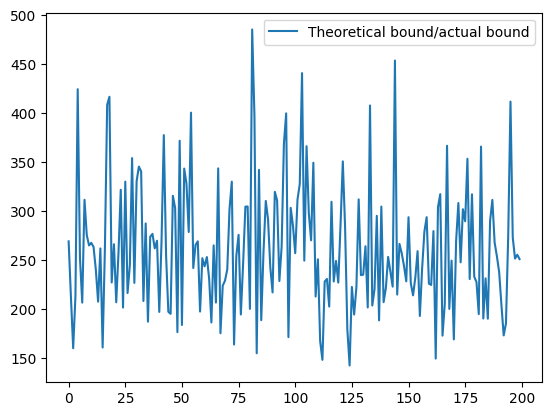

In [187]:
plt.plot(ratios, label="Theoretical bound/actual bound")
plt.legend()

In [188]:
print("Mean ratio:", sum(ratios)/len(ratios))

Mean ratio: 262.43581207596674
